<a href="https://colab.research.google.com/github/tasnim13/CS166_Synonymizer/blob/main/TH_CS166_Synonymizer_TextEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install biopython faiss-cpu pytorch_metric_learning rdkit

In [ ]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from pytorch_metric_learning import losses, miners

from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split

import faiss

# KEGG
from Bio.KEGG import REST
# other helpful utils
import requests
import time
import numpy as np
import random

In [ ]:
# Save the dataset to the shared drive
from google.colab import drive
drive.mount('/content/drive')
filepath_to_drive = '/content/drive/Shareddrives/CS166 - Synonymizer/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# THIS HAS ALREADY BEEN DONE, NO NEED TO RUN IT AGAIN
import time
import random
random.seed(7)

def get_kegg_synonyms(kegg_id):
    names = []
    search_results = REST.kegg_get(kegg_id).read()
    if not search_results:
        return names

    in_name_field = False
    name_lines = []

    for line in search_results.split("\n"):
        if line.startswith("NAME"):
            in_name_field = True
            name_lines.append(line[5:].strip())  # remove 'NAME ' label
        elif in_name_field:
            # continuation lines start with spaces
            if line.startswith(" "):
                name_lines.append(line.strip())
            else:
                break  # NAME field ended

    # Combine all lines and split by ";"
    all_names = " ".join(name_lines)
    names = [n.strip() for n in all_names.split(";") if n.strip()]

    return names

def add_kegg_id_synonyms_to_df(random_ids, df):
  for i, kegg_id in enumerate(random_ids):
      if i % 25 == 0:
        print(f'{i} KEGG IDs processed')
      synonyms = get_kegg_synonyms(kegg_id)
      for name in synonyms:
          df.loc[len(df)] = [name, kegg_id]

      time.sleep(3)
  return df

# grab all compounds
all_compounds_text = REST.kegg_list("compound").read()
# extarct just the ids
all_ids = [line.split("\t")[0].replace("cpd:", "") for line in all_compounds_text.strip().split("\n")]


N = 1000  # number
random_ids = random.sample(all_ids, N)
print(random_ids)

df = pd.DataFrame(columns=["compound", "label"])
df = add_kegg_id_synonyms_to_df(random_ids, df)

# More permenant - save to shared drive
df.to_csv(filepath_to_drive + "compound_labels.csv", index=False)

0 KEGG IDs processed
25 KEGG IDs processed
50 KEGG IDs processed
75 KEGG IDs processed
100 KEGG IDs processed
125 KEGG IDs processed
150 KEGG IDs processed
175 KEGG IDs processed
200 KEGG IDs processed
225 KEGG IDs processed
250 KEGG IDs processed
275 KEGG IDs processed
300 KEGG IDs processed
325 KEGG IDs processed
350 KEGG IDs processed
375 KEGG IDs processed
400 KEGG IDs processed
425 KEGG IDs processed
450 KEGG IDs processed
475 KEGG IDs processed
500 KEGG IDs processed
525 KEGG IDs processed
550 KEGG IDs processed
575 KEGG IDs processed
600 KEGG IDs processed
625 KEGG IDs processed
650 KEGG IDs processed
675 KEGG IDs processed
700 KEGG IDs processed
725 KEGG IDs processed
750 KEGG IDs processed
775 KEGG IDs processed
800 KEGG IDs processed
825 KEGG IDs processed
850 KEGG IDs processed
875 KEGG IDs processed
900 KEGG IDs processed
925 KEGG IDs processed
950 KEGG IDs processed
975 KEGG IDs processed


# Create a Dictionary of Sets of Synonyms for CPD ID

In [ ]:
df1 = pd.read_csv(filepath_to_drive + "compound_labels.csv")
synonyms_per_cpd_id_dict = {}
for i, row in df1.iterrows():
    if row.label in synonyms_per_cpd_id_dict.keys():
        synonyms_per_cpd_id_dict[row.label].add(row.compound)
    else:
        synonyms_per_cpd_id_dict[row.label] = {row.compound}

count_per_cpd_id = {}
for key, val_set in synonyms_per_cpd_id_dict.items():
    count_per_cpd_id[key] = len(val_set)

# Define Model and Dataset Classes and Helper Functions

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

class TextEncoderNTXent(nn.Module):
    def __init__(self, final_embedding_dim=256):
        super(TextEncoderNTXent, self).__init__()

        self.text_encoder = AutoModel.from_pretrained("allenai/scibert_scivocab_uncased")
        text_dim = self.text_encoder.config.hidden_size  # 768

        self.text_projection = nn.Sequential(
            nn.Linear(text_dim, text_dim),
            nn.ReLU(),
            nn.Linear(text_dim, final_embedding_dim)
        )

    def encode_text(self, text_inputs):
        outputs = self.text_encoder(**text_inputs)
        pooled_output = outputs.pooler_output if outputs.pooler_output is not None else outputs.last_hidden_state[:, 0, :]
        return self.text_projection(pooled_output)

    def forward(self, tokenized_batch):
        embeddings = self.encode_text(tokenized_batch)  # Fixed: was self.encode()
        normalized_embeddings = F.normalize(embeddings, dim=1)
        return normalized_embeddings

class SynonymDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.texts = self.dataframe['compound'].tolist()
        self.labels = self.dataframe['label'].tolist()

        # Map KEGG IDs to integer indices
        unique_labels = list(set(self.labels))
        self.label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()} # Add this line for reverse mapping
        self.label_indices = [self.label_to_idx[label] for label in self.labels]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label_idx = self.label_indices[idx]
        return text, label_idx

def collate_fn_scibert(batch):
    texts = [item[0] for item in batch]
    labels = [item[1] for item in batch]

    tokenized_inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors='pt',
        max_length=128
    )

    label_tensor = torch.tensor(labels, dtype=torch.long)
    return tokenized_inputs, label_tensor

def evaluate_retrieval(model, dataset, k=10):
    """
    Evaluate synonym retrieval accuracy on a dataset.

    Args:
        model: Your trained TextEncoderNTXent model
        dataset: SynonymDataset (val or test)
        k: Number of top neighbors to retrieve

    Returns:
        dict: Accuracy@1, Accuracy@5, Accuracy@10
    """
    global count_per_cpd_id

    model.eval()  # Set to evaluation mode

    # Get all embeddings and labels from the dataset
    all_embeddings = []
    all_labels = []

    dataloader = DataLoader(
        dataset,
        batch_size= 32,
        shuffle=False,
        collate_fn=collate_fn_scibert
    )

    with torch.no_grad():  # No gradient calculation
        for data, labels in dataloader:
            embeddings = model(data)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Stack all embeddings into one array
    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.array(all_labels)

    # Create the Faiss Index
    index = faiss.IndexFlatL2(256) # this is the dimension of the embeddings
    index.add(all_embeddings)

    # Get the mapping from integer index to original KEGG ID string
    idx_to_label_map = dataset.idx_to_label

    # Calculate retrieval accuracy
    any_correct_at_k = {1: 0, 5: 0, 10: 0}
    fraction_correct_at_k = {}

    total = len(all_embeddings)

    for i in range(total):
        query_emb = all_embeddings[i].reshape(1, -1)
        query_label_idx = all_labels[i] # This is the integer index

        # Convert integer index back to original KEGG ID string
        original_kegg_id = idx_to_label_map[query_label_idx]

        # # Compute cosine similarity to all other embeddings
        # similarities = cosine_similarity(query_emb, all_embeddings)[0]

        # # Get indices of nearest neighbors (excluding itself at position 0)
        # nearest_indices = np.argsort(similarities)[::-1][1:k+1]

        # Search using Faiss Index
        distance, nearest_indices = index.search(query_emb, k) # Output is guaranteed to be ordered from smallest to largest distance

        # Get labels of retrieved neighbors
        retrieved_labels_idx = all_labels[nearest_indices]
        # Convert retrieved integer labels back to original KEGG ID strings
        retrieved_labels_kegg_id = np.array([idx_to_label_map[idx] for idx in retrieved_labels_idx.flatten()]).reshape(retrieved_labels_idx.shape)

        # Check *how many* of the top-k matches are correct synonyms
        for k_val in [1, 5, 10]:
            if k_val <= k:
                if np.any(retrieved_labels_kegg_id[0, :k_val] == original_kegg_id):
                    any_correct_at_k[k_val] += 1
                    count_correct = (retrieved_labels_kegg_id[0, :k_val] == original_kegg_id).sum()
                    possible_correct = min([count_per_cpd_id[original_kegg_id], k_val]) # Use original_kegg_id here
                    fraction_correct = count_correct / possible_correct

                    if k_val in fraction_correct_at_k.keys():
                        fraction_correct_at_k[k_val].append(fraction_correct)
                    else:
                        fraction_correct_at_k[k_val] = [fraction_correct]

    # Calculate accuracy percentages
    caught_any_at_k = {k: (correct / total) * 100 for k, correct in any_correct_at_k.items()}
    fraction_caught_at_k = {k: np.mean(fraction_list) * 100 for k, fraction_list in fraction_correct_at_k.items() if len(fraction_list) > 0}

    return caught_any_at_k, fraction_caught_at_k

# Create the DataLoader

In [ ]:
# train, test and validate on all data
train_df = df1.copy()
val_df = df1.copy()
test_df = df1.copy()

# Create dataset and dataloader
train_dataset = SynonymDataset(train_df)
val_dataset = SynonymDataset(val_df)
test_dataset = SynonymDataset(test_df)

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    collate_fn=collate_fn_scibert
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn_scibert
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    collate_fn=collate_fn_scibert
)

#Training Loop

In [ ]:
# Initialize model
model = TextEncoderNTXent(final_embedding_dim=256)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
loss_func = losses.NTXentLoss(temperature=0.5)

num_epochs = 30
best_val_acc = 0

for epoch in range(num_epochs):
    # training on train_loader
    model.train()
    epoch_loss = 0

    for data, labels in train_loader:
        embeddings = model(data)
        loss = loss_func(embeddings, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    # validate on val_loader
    caught_any_at_k, fraction_caught_at_k = evaluate_retrieval(model, val_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {avg_loss:.4f}')
    print(f'  Queries that return a synonym@K=1: {caught_any_at_k[1]:.2f}%,  Average pct of molecule synonyms caught@K=1: {fraction_caught_at_k[1]:.2f}%')
    print(f'  Queries that return a synonym@K=5: {caught_any_at_k[5]:.2f}%,  Average pct of molecule synonyms caught@K=5: {fraction_caught_at_k[5]:.2f}%')
    print(f'  Queries that return a synonym@K=10: {caught_any_at_k[10]:.2f}%,  Average pct of molecule synonyms caught@K=10: {fraction_caught_at_k[10]:.2f}%')

    # Save best model *modifying this to check pct of all synonyms caught*
    if fraction_caught_at_k[5] > best_val_acc:
        best_val_acc = fraction_caught_at_k[5]
        torch.save(model.state_dict(), 'best_model.pt')
        print('Saved best model!')



model.load_state_dict(torch.load('best_model.pt'))
caught_any_at_k, fraction_caught_at_k = evaluate_retrieval(model, test_dataset)

print("\n=== FINAL TEST RESULTS ===")
print(f'Queries that return a synonym@K=5: {caught_any_at_k[5]:.2f}%,  Average pct of molecule synonyms caught@K=5: {fraction_caught_at_k[5]:.2f}%')



pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

Epoch 1/30
  Train Loss: 0.0460
  Queries that return a synonym@K=1: 100.00%,  Average pct of molecule synonyms caught@K=1: 100.00%
  Queries that return a synonym@K=5: 100.00%,  Average pct of molecule synonyms caught@K=5: 68.94%
  Queries that return a synonym@K=10: 100.00%,  Average pct of molecule synonyms caught@K=10: 70.05%
Saved best model!
Epoch 2/30
  Train Loss: 0.0485
  Queries that return a synonym@K=1: 100.00%,  Average pct of molecule synonyms caught@K=1: 100.00%
  Queries that return a synonym@K=5: 100.00%,  Average pct of molecule synonyms caught@K=5: 66.22%
  Queries that return a synonym@K=10: 100.00%,  Average pct of molecule synonyms caught@K=10: 67.33%
Epoch 3/30
  Train Loss: 0.0183
  Queries that return a synonym@K=1: 100.00%,  Average pct of molecule synonyms caught@K=1: 100.00%
  Queries that return a synonym@K=5: 100.00%,  Average pct of molecule synonyms caught@K=5: 67.44%
  Queries that return a synonym@K=10: 100.00%,  Average pct of molecule synonyms caught

In [ ]:
# Copied results into a pipe separated txt file in the shared drive
results = pd.read_csv(filepath_to_drive + "synonymizer_120325_results.txt", sep='|')
results['Any Synonym@1'] = results['Any Synonym@1'].apply(lambda x: float(x.strip('%'))/100)
results['Any Synonym@5'] = results['Any Synonym@5'].apply(lambda x: float(x.strip('%'))/100)
results['Any Synonym@10'] = results['Any Synonym@10'].apply(lambda x: float(x.strip('%'))/100)
results['Pct Synonyms@1'] = results['Pct Synonyms@1'].apply(lambda x: float(x.strip('%'))/100)
results['Pct Synonyms@5'] = results['Pct Synonyms@5'].apply(lambda x: float(x.strip('%'))/100)
results['Pct Synonyms@10'] = results['Pct Synonyms@10'].apply(lambda x: float(x.strip('%'))/100)

print(results.head())

   Epoch  Train Loss  Any Synonym@1  Pct Synonyms@1  Any Synonym@5  \
0      1      0.0460            1.0             1.0            1.0   
1      2      0.0485            1.0             1.0            1.0   
2      3      0.0183            1.0             1.0            1.0   
3      4      0.0224            1.0             1.0            1.0   
4      5      0.0463            1.0             1.0            1.0   

   Pct Synonyms@5  Any Synonym@10  Pct Synonyms@10  
0          0.6894             1.0           0.7005  
1          0.6622             1.0           0.6733  
2          0.6744             1.0           0.6850  
3          0.6506             1.0           0.6562  
4          0.6625             1.0           0.6683  


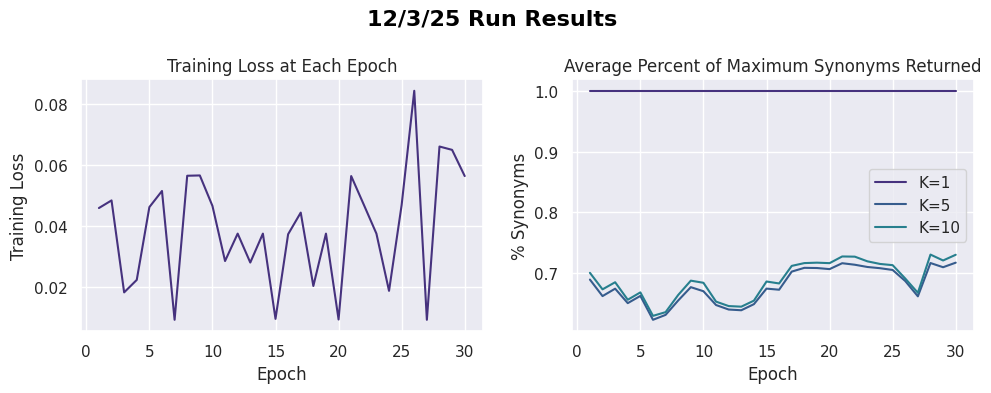

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_palette('viridis')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4)) # Adjust figsize as needed
fig.suptitle('12/3/25 Run Results with LR = 1e-5', fontsize=16, fontweight='bold', color='black')

# Plot on the first axis
ax1.plot(results['Epoch'], results['Train Loss'])
ax1.set_title('Training Loss at Each Epoch')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Training Loss')
ax1.grid(True)

# Plot on the second axis
ax2.plot(results['Epoch'],results['Pct Synonyms@1'], label='K=1')
ax2.plot(results['Epoch'],results['Pct Synonyms@5'], label='K=5')
ax2.plot(results['Epoch'],results['Pct Synonyms@10'], label='K=10')
ax2.set_title('Average Percent of Maximum Synonyms Returned')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('% Synonyms')
ax2.legend()
ax2.grid(True)

# Adjust layout and display
plt.tight_layout() # Adjusts subplot params for a tight layout
plt.show()